In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.lblnew.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.lblnew.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/lblnew/g1_threshold.py'>

In [2]:
%run param.py

In [3]:
NG_REFS = PARAM['ng_refs']
P_REFS, T_REFS = zip(*PARAM['ref_pts'])

In [4]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'ng_adju',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin',
            'option_compute_ktable',
            'option_compute_btable',
            'conc']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [5]:
analysis = scripts.Analysis()

In [6]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_FORTRAN
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.color = 'b'
crd.marker = None
crd.load_data()

In [7]:
def add_wgt_models():
    iggs = [10, 1]
    markers = [None, 'x']
    colors = ['r', 'c']
    linestyle = '-'

    df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                         'output_wfluxg.dat'), 
                            sep=r'\s+')

    df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wcoolrg.dat'), 
                             sep=r'\s+')

    for igg, marker, color in zip(iggs, markers, colors):

        flux_igg = df_wfluxg[df_wfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdx_igg = analysis.model('wgt_igg{}'.format(igg))
        crdx_igg.type_model = 'crd'
        crdx_igg.rundir = DIR_FORTRAN
        crdx_igg.fpath_flux = s_flux
        crdx_igg.fpath_coolr = s_coolr
        crdx_igg.color = color
        crdx_igg.marker = marker
        crdx_igg.linestyle = linestyle
        crdx_igg.load_data()
        
add_wgt_models()

In [8]:
def add_ktable_models():
    iggs = [10]
    markers = ['D',]
    color = 'g'
    linestyle = ':'

    df_wwfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wwfluxg.dat'), 
                             sep=r'\s+')

    df_wwcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                           'output_wwcoolrg.dat'), 
                              sep=r'\s+')

    for igg, marker in zip(iggs, markers):

        flux_igg = df_wwfluxg[df_wwfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wwcoolrg[df_wwcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdxx_igg = analysis.model('ktable_igg{}'.format(igg))
        crdxx_igg.type_model = 'crd'
        crdxx_igg.rundir = DIR_FORTRAN
        crdxx_igg.fpath_flux = s_flux
        crdxx_igg.fpath_coolr = s_coolr
        crdxx_igg.color = color
        crdxx_igg.marker = marker
        crdxx_igg.linestyle = linestyle
        crdxx_igg.load_data()
        
        

In [9]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [10]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [11]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [12]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [13]:
for name, value in sorted(PARAM.items()):
    print('{} = {}'.format(name, value))

atmpro = saw
band = 7
commitnumber = f17e0b2
conc = na
dv = 0.001
klin = 0
molecule = h2o
ng_adju = [0]
ng_refs = [7]
nv = 1000
option_compute_btable = 0
option_compute_ktable = 0
option_wgt_flux = 2
option_wgt_k = 1
ref_pts = [(600, 250)]
tsfc = 257
w_diffuse = [(2, 1.6, 1.6, 1.6, 1.6, 1.6, 1.8)]
wgt = [(0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.9)]


In [14]:
fig.display_hrefanchor()

In [15]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [16]:
table_dgdgs.display_hrefanchor()

In [17]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [18]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [19]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

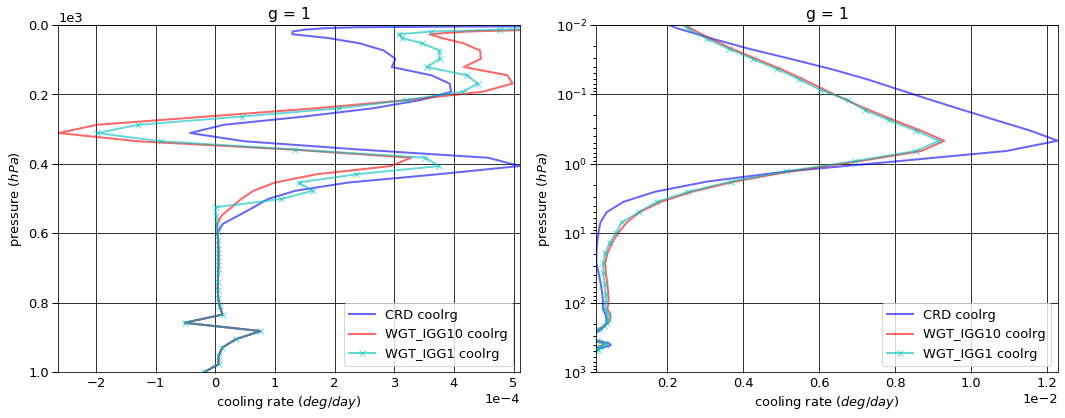

# Figure: cooling rate g-group 2

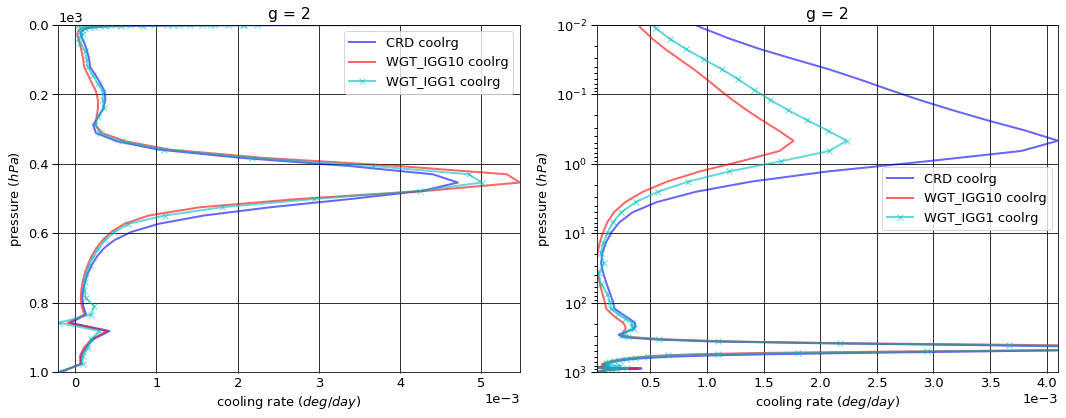

# Figure: cooling rate g-group 3

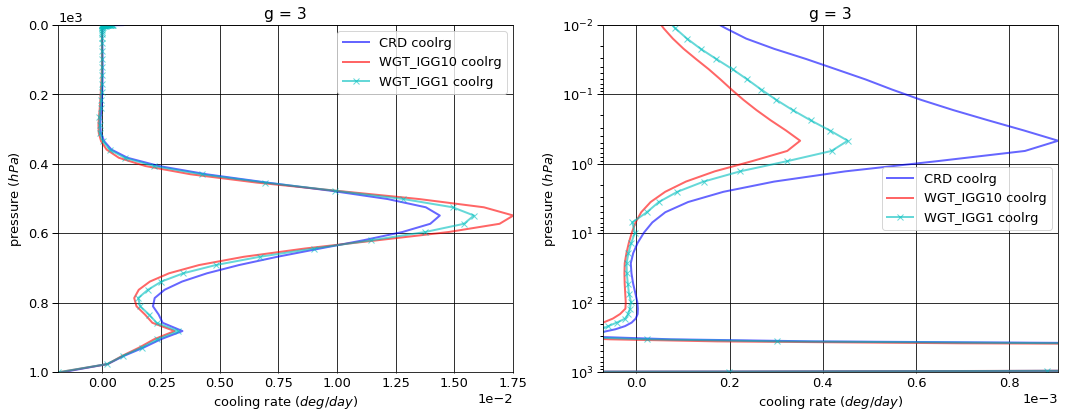

# Figure: cooling rate g-group 4

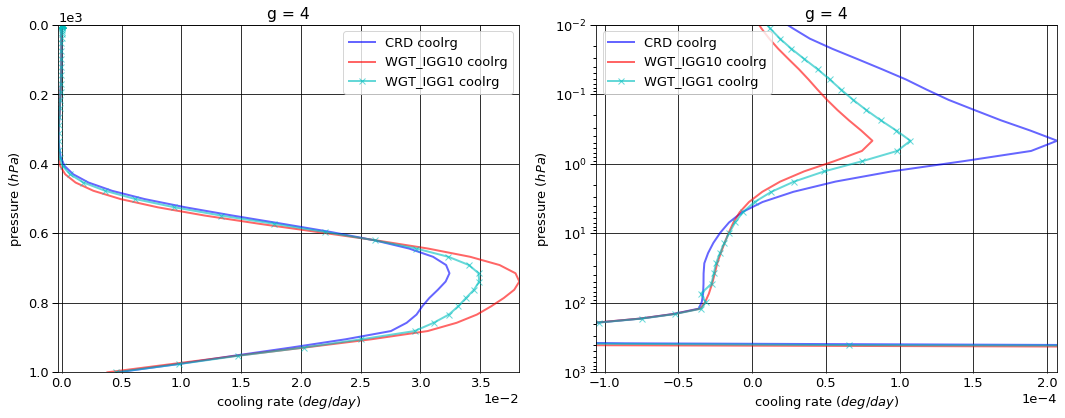

# Figure: cooling rate g-group 5

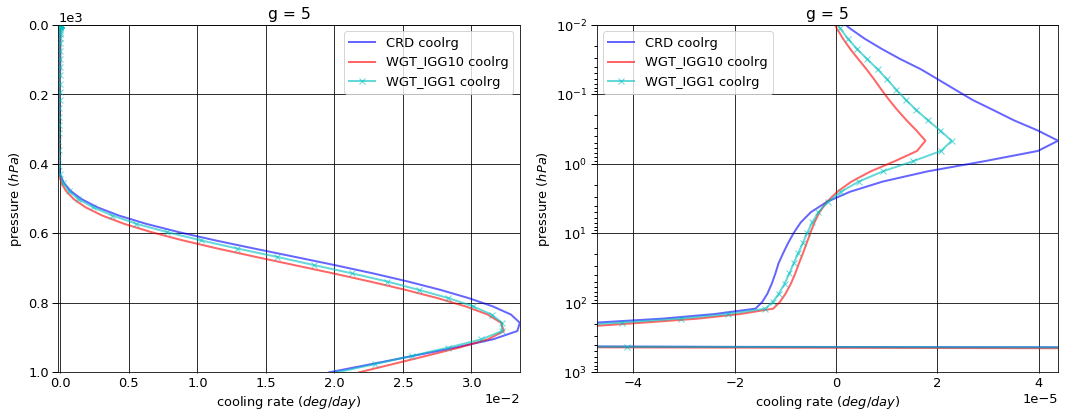

# Figure: cooling rate g-group 6

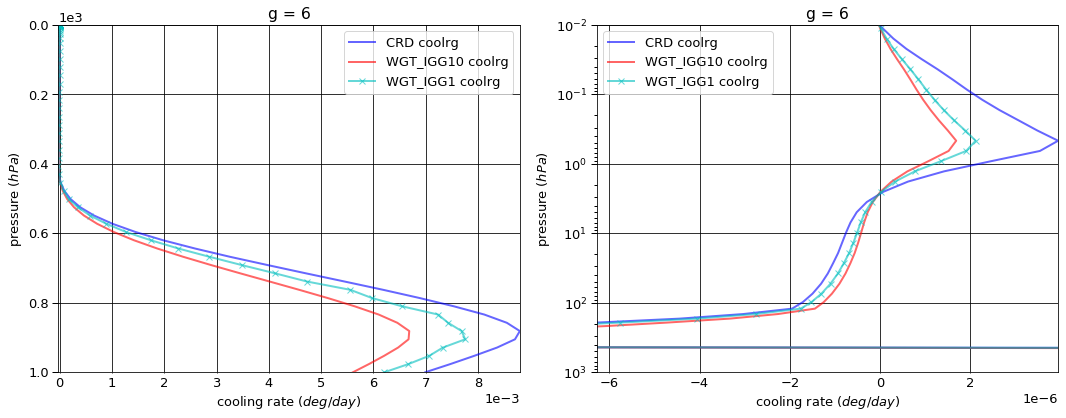

# Figure: cooling rate g-group 7

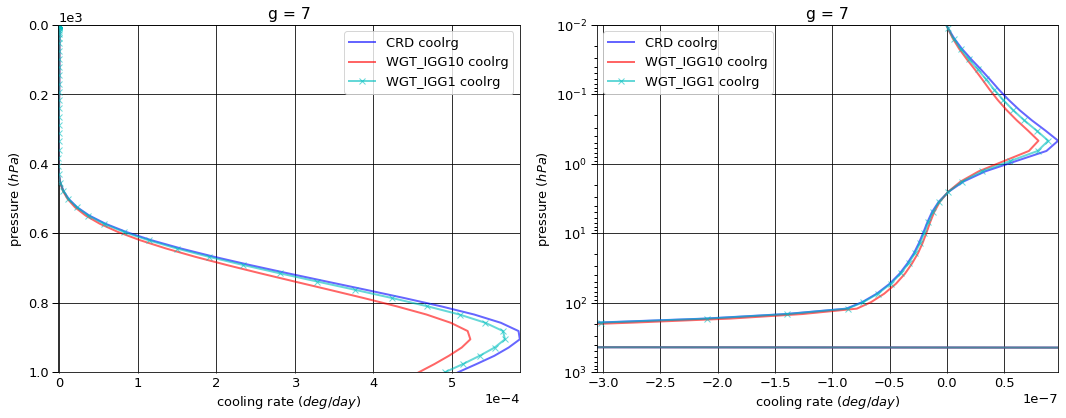

# Figure: cooling rate g-group total

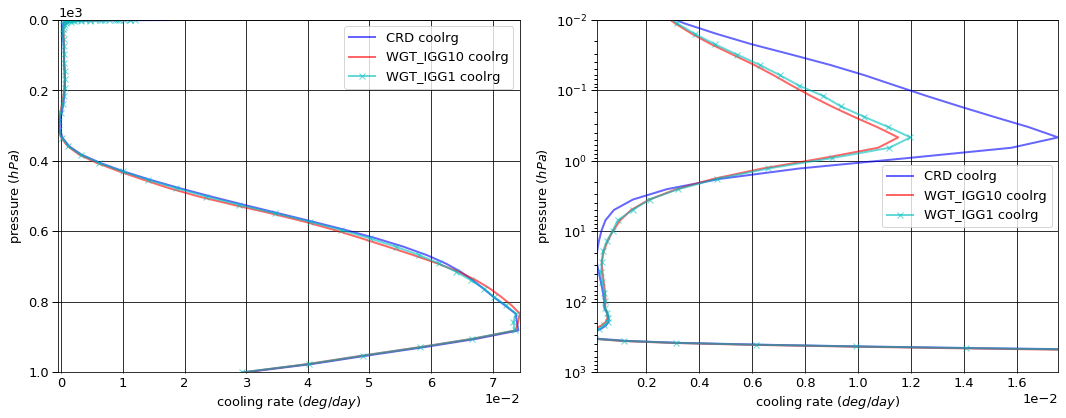

In [20]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [21]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.017562  0.000000 -0.017562
  1013.0   76    -0.064743  0.064807  0.000065
2 0.0      1     -0.099215  0.000000 -0.099215
  1013.0   76    -0.257375  0.258114  0.000739
3 0.0      1     -0.420192  0.000000 -0.420192
  1013.0   76    -0.709774  0.719250  0.009476
4 0.0      1     -1.548516  0.000000 -1.548516
  1013.0   76    -1.861798  1.752981 -0.108817
5 0.0      1     -2.710313  0.000000 -2.710313
  1013.0   76    -2.819904  1.380115 -1.439790
6 0.0      1     -2.913682  0.000000 -2.913682
  1013.0   76    -2.928949  0.328371 -2.600578
7 0.0      1     -0.914687  0.000000 -0.914687
  1013.0   76    -0.915487  0.021357 -0.894130


WGT_IGG10


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.016245  0.000000 -0.016245
  1013.0   76    -0.064743  0.064807  0.000065
2 0.0      1     -0.095124  0.000000 -0.095124
  1013.0   76    -0.257375  0.257986  0.000611
3 0.0      1     -0.415750  0.000000 -0.415750
  1013.0   76    -0.709774  0.718314  0.008540
4 0.0      1     -1.566364  0.000000 -1.566364
  1013.0   76    -1.861798  1.848075 -0.013723
5 0.0      1     -2.739026  0.000000 -2.739026
  1013.0   76    -2.819904  1.268375 -1.551530
6 0.0      1     -2.918340  0.000000 -2.918340
  1013.0   76    -2.928949  0.247323 -2.681627
7 0.0      1     -0.914793  0.000000 -0.914793
  1013.0   76    -0.915487  0.018949 -0.896539


WGT_IGG1


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.016472  0.000000 -0.016472
  1013.0   76    -0.064743  0.064807  0.000065
2 0.0      1     -0.095280  0.000000 -0.095280
  1013.0   76    -0.257375  0.258126  0.000752
3 0.0      1     -0.414584  0.000000 -0.414584
  1013.0   76    -0.709774  0.718891  0.009117
4 0.0      1     -1.553710  0.000000 -1.553710
  1013.0   76    -1.861798  1.810776 -0.051022
5 0.0      1     -2.722318  0.000000 -2.722318
  1013.0   76    -2.819904  1.312562 -1.507343
6 0.0      1     -2.915538  0.000000 -2.915538
  1013.0   76    -2.928949  0.289061 -2.639888
7 0.0      1     -0.914713  0.000000 -0.914713
  1013.0   76    -0.915487  0.020631 -0.894856


WGT_IGG10 - CRD


flug      fldg     fnetg
g pressure level                                  
1 0.0      1      1.317043e-03  0.000000  0.001317
  1013.0   76     0.000000e+00  0.000000  0.000000
2 0.0      1      4.090255e-03  0.000000  0.004090
  1013.0   76     0.000000e+00 -0.000128 -0.000128
3 0.0      1      4.442620e-03  0.000000  0.004443
  1013.0   76     0.000000e+00 -0.000936 -0.000936
4 0.0      1     -1.784870e-02  0.000000 -0.017849
  1013.0   76     0.000000e+00  0.095094  0.095094
5 0.0      1     -2.871210e-02  0.000000 -0.028712
  1013.0   76     0.000000e+00 -0.111740 -0.111740
6 0.0      1     -4.658600e-03  0.000000 -0.004659
  1013.0   76    -4.440892e-16 -0.081049 -0.081049
7 0.0      1     -1.056500e-04  0.000000 -0.000106
  1013.0   76     0.000000e+00 -0.002409 -0.002409


WGT_IGG1 - CRD


flug      fldg     fnetg
g pressure level                                  
1 0.0      1      1.090435e-03  0.000000  0.001090
  1013.0   76     0.000000e+00  0.000000  0.000000
2 0.0      1      3.934825e-03  0.000000  0.003935
  1013.0   76     0.000000e+00  0.000012  0.000012
3 0.0      1      5.608410e-03  0.000000  0.005608
  1013.0   76     0.000000e+00 -0.000359 -0.000359
4 0.0      1     -5.194600e-03  0.000000 -0.005195
  1013.0   76     0.000000e+00  0.057795  0.057795
5 0.0      1     -1.200460e-02  0.000000 -0.012005
  1013.0   76     0.000000e+00 -0.067553 -0.067553
6 0.0      1     -1.856700e-03  0.000000 -0.001857
  1013.0   76    -4.440892e-16 -0.039310 -0.039310
7 0.0      1     -2.625000e-05  0.000000 -0.000026
  1013.0   76     0.000000e+00 -0.000726 -0.000726

# Table: cooling rate. g-groups 


CRD


coolrg
g pressure    layer              
1 0.000312    1     -1.223893e-03
  1001.112500 75    -1.892821e-05
2 0.000312    1      1.225870e-06
  1001.112500 75    -2.047563e-04
3 0.000312    1     -7.766846e-06
  1001.112500 75    -1.731032e-03
4 0.000312    1     -3.176135e-05
  1001.112500 75     4.675167e-03
5 0.000312    1     -9.244265e-06
  1001.112500 75     1.962454e-02
6 0.000312    1     -7.279462e-07
  1001.112500 75     6.993144e-03
7 0.000312    1     -1.685644e-08
  1001.112500 75     5.076367e-04


WGT_IGG10


coolrg
g pressure    layer              
1 0.000312    1      3.425393e-04
  1001.112500 75    -1.892821e-05
2 0.000312    1      1.097764e-05
  1001.112500 75    -1.736268e-04
3 0.000312    1     -1.893544e-05
  1001.112500 75    -1.878060e-03
4 0.000312    1     -1.722617e-05
  1001.112500 75     3.816580e-03
5 0.000312    1     -4.819772e-06
  1001.112500 75     2.180280e-02
6 0.000312    1     -3.390262e-07
  1001.112500 75     5.608599e-03
7 0.000312    1     -1.407956e-08
  1001.112500 75     4.576735e-04


WGT_IGG1


coolrg
g pressure    layer              
1 0.000312    1      2.938951e-04
  1001.112500 75    -1.892821e-05
2 0.000312    1      3.125216e-05
  1001.112500 75    -2.081840e-04
3 0.000312    1     -1.664387e-05
  1001.112500 75    -1.883574e-03
4 0.000312    1     -1.799040e-05
  1001.112500 75     4.528484e-03
5 0.000312    1     -5.538868e-06
  1001.112500 75     2.021555e-02
6 0.000312    1     -4.146715e-07
  1001.112500 75     6.210484e-03
7 0.000312    1     -1.553555e-08
  1001.112500 75     4.909403e-04


WGT_IGG10 - CRD


coolrg
g pressure    layer              
1 0.000312    1      1.566432e-03
  1001.112500 75     0.000000e+00
2 0.000312    1      9.751771e-06
  1001.112500 75     3.112959e-05
3 0.000312    1     -1.116859e-05
  1001.112500 75    -1.470276e-04
4 0.000312    1      1.453519e-05
  1001.112500 75    -8.585867e-04
5 0.000312    1      4.424493e-06
  1001.112500 75     2.178252e-03
6 0.000312    1      3.889200e-07
  1001.112500 75    -1.384545e-03
7 0.000312    1      2.776885e-09
  1001.112500 75    -4.996322e-05


WGT_IGG1 - CRD


coolrg
g pressure    layer              
1 0.000312    1      1.517788e-03
  1001.112500 75     0.000000e+00
2 0.000312    1      3.002629e-05
  1001.112500 75    -3.427620e-06
3 0.000312    1     -8.877023e-06
  1001.112500 75    -1.525424e-04
4 0.000312    1      1.377095e-05
  1001.112500 75    -1.466821e-04
5 0.000312    1      3.705397e-06
  1001.112500 75     5.910100e-04
6 0.000312    1      3.132747e-07
  1001.112500 75    -7.826597e-04
7 0.000312    1      1.320897e-09
  1001.112500 75    -1.669640e-05

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-8.624167,0.000000,-8.624167
1013.0,76,-9.558030,4.524995,-5.033035



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-8.665642,0.000000,-8.665642
1013.0,76,-9.558030,4.423828,-5.134203



WGT_IGG1


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-8.632615,0.000000,-8.632615
1013.0,76,-9.558030,4.474855,-5.083175



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-0.041475,0.000000,-0.041475
1013.0,76,0.000000,-0.101167,-0.101167



WGT_IGG1 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-0.008448,0.00000,-0.008448
1013.0,76,0.000000,-0.05014,-0.050140


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,-0.001272
1001.112500,75,0.029846



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,0.000312
1001.112500,75,0.029615



WGT_IGG1


,,coolrg
pressure,layer,
0.000312,1,0.000285
1001.112500,75,0.029335



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,0.001584
1001.112500,75,-0.000231



WGT_IGG1 - CRD


,,coolrg
pressure,layer,
0.000312,1,0.001557
1001.112500,75,-0.000511


In [22]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.008442,0.006700
2,0.031667,0.026712
3,0.084558,0.073792
4,0.218406,0.193706
5,0.300933,0.294683
6,0.277224,0.307781
7,0.078770,0.096626


In [23]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,1.695655e-20
2,2.527212e-21
3,3.766568e-22
4,5.613710e-23
5,8.366699e-24
6,1.246977e-24
7,1.858499e-25


In [24]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [25]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,1.695655e-20,NaN,0.008442,0.006700,0.008442,0.006700,600.0
2,2.527212e-21,0.14904,0.031667,0.026712,0.040109,0.033412,600.0
3,3.766568e-22,0.14904,0.084558,0.073792,0.124667,0.107205,600.0
4,5.613710e-23,0.14904,0.218406,0.193706,0.343073,0.300910,600.0
5,8.366699e-24,0.14904,0.300933,0.294683,0.644006,0.595593,600.0
6,1.246977e-24,0.14904,0.277224,0.307781,0.921230,0.903374,600.0
7,1.858499e-25,0.14904,0.078770,0.096626,1.000000,1.000000,600.0


In [26]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

In [27]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
